# Flight Delay Classifier v3
This go round, the goal is to do everything I did correclty in v2, but make it cleaner and easier to read. I am also going to be pairing this with my medium write-ups so I will need to make sure I can easily process the data with or without the weather features as that will come in a later post. That means making changes like:
* Dropping all unnecessary features from the get-go.
* Training and evaluating models in discrete sections that are easily compared.
* Writing up proper conclusions at the end.
* Using the first person singular instead of the first person plural because I am not royalty.

In [1]:
import os
import fnmatch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Exploration
### Loading the Data
My first step is to physically load the data. Since last time, I have aggregated all of the flight info for PDX into a single file containing every carrier's data. I will load this and the weather data into two dataframes.

In [2]:
delay_df = pd.read_csv('C:/Users/dloso/Documents/Data Science/flight-delay-forecasting/data/delays/concatenated_delays/PDX_delays.csv')
weather_df = pd.read_csv('C:/Users/dloso/Documents/Data Science/flight-delay-forecasting/data/weather/PDX_weather.csv')

In [3]:
delay_df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594126 entries, 0 to 594125
Data columns (total 18 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Unnamed: 0                                594126 non-null  int64  
 1   Carrier Code                              594126 non-null  object 
 2   Date (MM/DD/YYYY)                         594126 non-null  object 
 3   Flight Number                             594126 non-null  float64
 4   Tail Number                               593220 non-null  object 
 5   Destination Airport                       594126 non-null  object 
 6   Scheduled departure time                  594126 non-null  object 
 7   Actual departure time                     594126 non-null  object 
 8   Scheduled elapsed time (Minutes)          594126 non-null  float64
 9   Actual elapsed time (Minutes)             594126 non-null  float64
 10  Departure delay (Min

## Examining Possible Features
I will be checking for trends among the features and the target variable--the flight delay status. Other delay variables outside of 'Departure delay (Minutes)' will be ignored as these are just subsets of the total delay.

In [4]:
delay_df['Delayed'] = np.where(delay_df['Departure delay (Minutes)'] > 0, 1, 0)

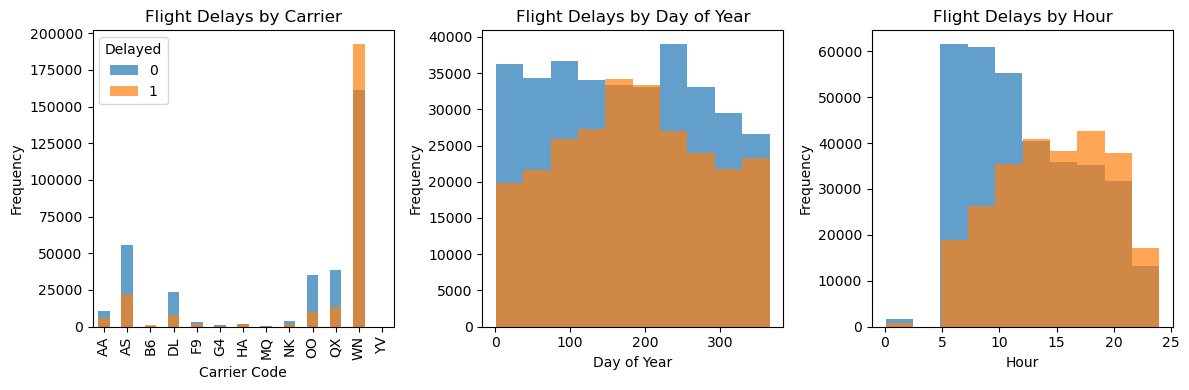

In [5]:
delay_df['DayOfYear'] = pd.to_datetime(delay_df['Date (MM/DD/YYYY)']).dt.dayofyear
delay_df['Hour'] = pd.to_datetime(delay_df['Scheduled departure time'], format='%H:%M').dt.hour + pd.to_datetime(delay_df['Scheduled departure time'], format='%H:%M').dt.minute / 60

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
delay_df.groupby(['Carrier Code', 'Delayed']).size().unstack(fill_value=0)[0].plot(
    kind='bar', 
    stacked=True,
    alpha=0.7,
    legend=True,
    title='Flight Delays by Carrier',
    label='0',
    ax=axs[0],
    color='tab:blue'
)
delay_df.groupby(['Carrier Code', 'Delayed']).size().unstack(fill_value=0)[1].plot(
    kind='bar', 
    stacked=True,
    alpha=0.7,
    legend=True,
    label='1',
    ax=axs[0],
    color='tab:orange'
)
axs[0].set_xlabel('Carrier Code')
axs[0].set_ylabel('Frequency')
axs[0].legend(title='Delayed')

delay_df.groupby('Delayed')['DayOfYear'].plot(
    kind='hist',
    stacked=True,
    alpha=0.7,
    bins=10,  # Adjust the number of bins as needed
    # legend=True,
    title='Flight Delays by Day of Year',
    ax=axs[1]
)
axs[1].set_xlabel('Day of Year')
axs[1].set_ylabel('Frequency')

delay_df.groupby('Delayed')['Hour'].plot(
    kind='hist',
    stacked=True,
    alpha=0.7,
    bins=10,  # Adjust the number of bins as needed
    # legend=True,
    title='Flight Delays by Hour',
    ax=axs[2]
)
axs[2].set_xlabel('Hour')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('C:/Users/dloso/Downloads/Delays_by_Carrier_DayOfYear_Hour_PDX.png')

In [6]:
dest_act_df = pd.DataFrame(delay_df.groupby('Destination Airport')['Delayed'].value_counts())
dest_prop_df = pd.DataFrame(delay_df.groupby('Destination Airport')['Delayed'].value_counts(normalize=True))
dest_df = pd.concat([dest_act_df, dest_prop_df], axis=1)
dest_df.columns = ['Count', 'Proportion']
dest_df = dest_df.reset_index()
dest_df = dest_df[dest_df['Delayed'] == 1]
print(dest_df.sort_values(by='Proportion', ascending=False).head(20))

    Destination Airport  Delayed  Count  Proportion
34                  CLE        1      1    1.000000
155                 PBI        1      4    0.800000
157                 PDX        1    365    0.762004
121                 MEM        1   1327    0.647001
105                 LGA        1   3874    0.642029
24                  BUF        1     17    0.629630
127                 MKE        1   1034    0.629337
175                 RDU        1    992    0.625473
179                 RSW        1    570    0.615551
37                  CMH        1   1087    0.613085
45                  DAL        1    339    0.603203
93                  JAX        1    336    0.600000
107                 LGB        1   1433    0.599833
28                  BWI        1   4762    0.594433
119                 MDW        1   7746    0.594018
213                 TPA        1   3499    0.584238
91                  IND        1   1589    0.579082
32                  CHS        1    928    0.573902
159         

In [7]:
tail_no_act_df = pd.DataFrame(delay_df.groupby('Tail Number')['Delayed'].value_counts())
tail_no_prop_df = pd.DataFrame(delay_df.groupby('Tail Number')['Delayed'].value_counts(normalize=True))
tail_no_df = pd.concat([tail_no_act_df, tail_no_prop_df], axis=1)
tail_no_df.columns = ['Count', 'Proportion']
tail_no_df = tail_no_df.reset_index()
tail_no_df = tail_no_df[tail_no_df['Delayed'] == 1].sort_values(by='Proportion', ascending=False)
print(tail_no_df[tail_no_df['Count'] > 20].head(20))

     Tail Number  Delayed  Count  Proportion
2475      N391HA        1     43    0.704918
4752      N745SW        1    113    0.693252
2405      N382HA        1     38    0.678571
6756      N8941Q        1     35    0.673077
4502      N711HK        1     84    0.666667
2451      N388HA        1     41    0.661290
2429      N385HA        1     37    0.660714
4567      N717SA        1     98    0.657718
2437      N386HA        1     44    0.656716
6766      N8946L        1     40    0.655738
2514      N396HA        1     34    0.653846
6434      N8808Q        1    313    0.653445
2389      N380HA        1     30    0.652174
6764      N8945Q        1     33    0.647059
6428      N8805L        1    309    0.646444
6426      N8804L        1    307    0.643606
6746      N8938Q        1     32    0.640000
6180      N8707P        1    220    0.639535
6784      N8953Q        1     23    0.638889
6792      N8957Q        1     23    0.638889


## Collinearity
Given the large chi-squared value between 'Flight Number' and 'Destination Airport', I am inclined to follow my intuition that these two variables are correlated. The 'Flight Number' is thus unlikely to add additional detail to the model that isn't already captured in 'Destination Airport' (and likely other features as well).

In [8]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(delay_df['Flight Number'], delay_df['Destination Airport'])

chi2_statistic, p_value, dof, expected_freq = chi2_contingency(contingency_table)

print(f'\nChi-squared Statistic: {chi2_statistic}')
print(f'P-value: {p_value}')


Chi-squared Statistic: 25075278.337462157
P-value: 0.0


# Data Cleaning
## Reducing Dimensionality
I will immediately be dropping features from the dataframe that did not pass the "smell test" from the data exploration. 

In [9]:
delay_df = delay_df[['Carrier Code', 'DayOfYear', 'Hour', 'Destination Airport', 'Tail Number', 'Delayed']]
delay_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594126 entries, 0 to 594125
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Carrier Code         594126 non-null  object 
 1   DayOfYear            594126 non-null  int32  
 2   Hour                 594126 non-null  float64
 3   Destination Airport  594126 non-null  object 
 4   Tail Number          593220 non-null  object 
 5   Delayed              594126 non-null  int64  
dtypes: float64(1), int32(1), int64(1), object(3)
memory usage: 24.9+ MB


## NaN Checks
Many of the machine learning models I will be testing cannot natively handle NaN values so I'll need to make sure to identify NaNs and either drop or replace them appropriately. Since there are only NaN values in the Tail Number feature, it simplifies my approach. Dropping the rows with NaNs would be acceptable since there are so few relative to the total number of data points, but I can do better in this instance. I will fill the values based on the most common value shared by similar rows. For instance, if Tail Number is NaN, I would fill it with the most common Tail Number from rows with the same Carrier Code and Destination Airport.

In [10]:
delay_df.isna().sum()

Carrier Code             0
DayOfYear                0
Hour                     0
Destination Airport      0
Tail Number            906
Delayed                  0
dtype: int64

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

class GroupedModeImputer(BaseEstimator, TransformerMixin):
    def __init__(self, group_cols, target_col):
        self.group_cols = group_cols
        self.target_col = target_col
        self.impute_map_ = None
        self.global_mode_ = None

    def fit(self, X, y=None):
        # Calculate mode for each group. Use 'Unknown' if there is no mode
        self.impute_map_ = X.groupby(self.group_cols)[self.target_col].apply(
            lambda x: x.mode().iloc[0] if not x.mode().empty else 'Unknown'
        ).to_dict()
        
        return self

    def transform(self, X):
        check_is_fitted(self)
        X = X.copy()
        
        # Create a key for mapping groups and then fill na values
        group_keys = X[self.group_cols].apply(tuple, axis=1)        
        mask = X[self.target_col].isna()        
        X.loc[mask, self.target_col] = group_keys[mask].map(self.impute_map_)
        
        return X

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

impute_tail = GroupedModeImputer(group_cols=['Carrier Code', 'Destination Airport'], target_col='Tail Number')

cat_pipeline = Pipeline([
    ('fill_tail', impute_tail),
    ('encode', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

## Cyclic Transformations of DayOfYear and Hour
To ensure that neighboring days and hours are treated similarly even when the values appear far apart (e.g. 2300 and 0100), I will transform them with sine and cosine. This will ensure that the cyclic nature of the data is preserved and appropriately incorporated by the models.

In [25]:
from sklearn.preprocessing import FunctionTransformer

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

## Column Transformer
Finally, toss the categorical pipeline and cyclic transformers into a column transformer to make sure it can be easily run on the data.

In [26]:
from sklearn.compose import ColumnTransformer

cat_cols = ['Carrier Code', 'Destination Airport', 'Tail Number']
date_cols = ['DayOfYear']
time_cols = ['Hour']
cyclic_cossin_transformer = ColumnTransformer(
    transformers=[
        ('categorical', cat_pipeline, cat_cols),
        ('day_sin', sin_transformer(365), date_cols),
        ('day_cos', cos_transformer(365), date_cols),
        ('hour_sin', sin_transformer(24), time_cols),
        ('hour_cos', cos_transformer(24), time_cols),
    ]
)